<a href="https://colab.research.google.com/github/Lu-David/CovariateShift/blob/3_06/MNIST_RBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Data

In [1]:
import torchvision
import torchvision.datasets as datasets
import torch

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



tensor(5)


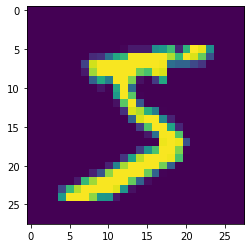

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.imshow(mnist_trainset.data[0])
print(mnist_trainset.targets[0])

# Util Functions and Classes


In [57]:
def unison_shuffled_copies(a, b):
  # Shuffle both arrays in unison
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

## Model

In [58]:
import torch.nn as nn

class RBAGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, output, r_st):
        pred = torch.sigmoid(output * r_st)
        ctx.save_for_backward(pred)
        return pred

    @staticmethod
    def backward(ctx, y):
        prob, = ctx.saved_tensors
        grad_temp = y.clone()
        grad_input = (prob - grad_temp)
        return grad_input, None
        
class RBAClassifierMLP(nn.Module):
    """
    Multi (3) layer robust bias aware (RBA) classifier
    """
    def __init__(self, in_features = 2, out_features = 1, bias = True):
        super(RBAClassifierMLP, self).__init__()

        self.activation = nn.Sigmoid()
        self.layer1 = nn.Linear(in_features, 16, bias = bias)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, out_features)

    def forward(self, input, r_st):
        """[summary]

        Args:
            input (torch.Tensor): features

        Returns:
            torch.Tensor: predictions
        """
        output = self.activation(self.layer1(input))
        output = self.activation(self.layer2(output))
        output = self.layer3(output)

        return RBAGrad.apply(output, r_st)

## Train

In [71]:
import torch
import torch.nn as nn
import numpy as np


def rba_train(X_s, y_s, r_st, r_ts, max_itr = 10000, lr = 0.01, weight_decay = 0.1):
    # General function for training RBA, IW, or LOG models

    _, n_col = X_s.shape
    _, out_features = y_s.shape

    # bias = True
    # if True: # not torch.equal(r_ts, torch.ones(r_ts.shape)):
    bias = False
    X = torch.cat((
        torch.ones(r_ts.shape), 
        X_s
    ), dim = 1)
    
    model = RBAClassifierMLP(in_features = n_col + int(not bias), out_features=out_features, bias = bias)
        
    loss_fn = nn.BCELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

    F = X * r_ts.detach()

    model.train()

    for i in range(max_itr + 1): 
        optimizer.zero_grad()
        
        outputs = model.forward(F, r_st)
        outputs.backward(y_s)
        optimizer.step()
        
        loss = loss_fn(outputs.squeeze(), y_s.squeeze())
        if i % 1000 == 0:
            print(f"Loss at step {i}: {float(loss.data)}")

    return model

## Test

In [61]:
def log_test(model, X_t, y_t, r_st):
    n_row, _ = X_t.shape
    
    model.eval()

    loss_fn = nn.BCELoss() 
    F = torch.cat((
        torch.ones(r_st.shape), 
        X_t
        ), dim = 1)
    outputs = model(F, r_st)
    loss = loss_fn(outputs.squeeze(), y_t.squeeze())
    acc = torch.sum(torch.round(outputs) == y_t) / n_row
    print(f"Target Loss: {loss}. Target Accuracy: {acc}")
    return loss, outputs, acc

In [62]:
def binary_ece(pred_y_pairs : np.array, n_bins = 10):
  '''
    Calculate Expected Calibration Error (ECE) of predictions and true labels
    https://jamesmccaffrey.wordpress.com/2021/01/22/how-to-calculate-expected-calibration-error-for-multi-class-classification/ 

            Parameters:
                    pred_y_pairs ((n by 2) np.array): Two columns where first column is predicted values and second column is true labels 
                    n_bins (int): number of bins to partition [0, 1] by

            Returns:
                    binary_sum (str): Binary string of the sum of a and b
    '''

  bin_size = 1 / n_bins
  x = np.linspace(0, 1 - bin_size, n_bins)
  diff_array = np.zeros((n_bins))
  acc_array = np.zeros((n_bins))
  pos_freq_array = np.zeros((n_bins))
  count_array = np.zeros((n_bins))

  for i in range(n_bins):
    lower = i * bin_size
    upper = (i + 1) * bin_size
    
    temp = pred_y_pairs[np.logical_and(pred_y_pairs[:,0] >= lower, pred_y_pairs[:,0] < upper)]
    n = len(temp)

    count_array[i] = n
    acc = np.sum(np.round(temp[:, 0]) == temp[:, 1]) / n
    pos_freq = np.sum(1 == temp[:, 1]) / n
    avg_conf = np.mean(temp[:, 0])
    diff = np.abs(acc - avg_conf)
    
    diff_array[i] = diff
    acc_array[i] = acc
    pos_freq_array[i] = pos_freq

  
  ece = np.sum((diff_array * count_array)) / len(pred_y_pairs)

  # # Plot Reliability Diagram (pos_freq vs bins)
  # plt.bar(x, pos_freq_array, width=bin_size, align='edge')
  # plt.title(f"Reliability Diagram. ECE: {ece}")
  # plt.xlabel("Mean Predicted Value")
  # plt.xlabel("Fraction of positives")

  return ece


In [63]:
# test_X_flattened = torch.flatten(torch.Tensor(test_X), start_dim=1)
# test_Y = torch.Tensor(test_Y)
# n, _ = test_X_flattened.shape
# r_st = torch.ones((n, 1))

# loss, outputs, acc = log_test(model, test_X_flattened, test_Y, torch.ones((test_X_flattened.shape[0], 1)))

# low_conf_samples = test_X[np.where(np.abs(outputs.detach().numpy() - 0.5) < 0.15)[0]]
# low_conf_labels = test_Y[np.where(np.abs(outputs.detach().numpy() - 0.5) < 0.15)[0]]

# i = 2
# j = 2
# fig, ax = plt.subplots(i,j)
# for x in range(i):
#   for y in range(j):
#     ax[x][y].imshow(low_conf_samples[x * i + y])
#     ax[x][y].title.set_text(int(low_conf_labels[x * i + y].item()))

# # fig.set_tight_layout(True)
# print(len(low_conf_labels))
# pred_y_pairs = np.concatenate((outputs.detach().numpy(), test_Y.detach().numpy()), axis=1)
# ece = binary_ece(pred_y_pairs, n_bins=6)
# print(ece)

## Density Estimation

### Classifier [INCOMPLETE]

In [11]:
from sklearn.preprocessing import PolynomialFeatures
import torch

def get_poly_data(x, poly_features):
    poly = PolynomialFeatures(poly_features, include_bias=False)
    return torch.FloatTensor(poly.fit_transform(x))

In [12]:
def get_lrdr_estimator(X_s, X_t, weight_decays=[0.01]):

    poly_features = 1
    
    X_s = get_poly_data(X_s, poly_features)
    X_t = get_poly_data(X_t, poly_features)

    X_s = torch.Tensor(X_s)
    X_t = torch.Tensor(X_t)

    ns_row, _ = X_s.shape
    nt_row, _ = X_t.shape

    inda_s = np.arange(ns_row)
    inda_t = np.arange(nt_row)

    nv_s = int(np.floor(0.1 * ns_row))
    nv_t = int(np.floor(0.1 * nt_row))

    indv_s = np.random.permutation(ns_row)[:nv_s] 
    indv_t = np.random.permutation(nt_row)[:nv_t]

    indt_s = np.setdiff1d(inda_s, indv_s)
    indt_t = np.setdiff1d(inda_t, indv_t)

    X_train = torch.cat((torch.FloatTensor(X_s[indt_s, :]), torch.FloatTensor(X_t[indt_t, :])))
    X_valid = torch.cat((torch.FloatTensor(X_s[indv_s, :]), torch.FloatTensor(X_t[indv_t, :])))

    ones_train = torch.ones((X_train.shape[0], 1))
    ones_valid = torch.ones((X_valid.shape[0], 1))
    ones_all = torch.cat((ones_train, ones_valid))
    
    y_train = torch.cat((torch.ones((ns_row - nv_s, 1)), torch.zeros((nt_row - nv_t, 1)) ))
    y_valid = torch.cat((torch.ones((nv_s, 1)), torch.zeros((nv_t, 1)) ))
    
    losses = torch.zeros((len(weight_decays), 1))
    for i, lamb in enumerate(weight_decays):
        model = rba_train(X_train, y_train, ones_train, ones_train, max_itr=1500, weight_decay=lamb)
        loss, pred, acc = log_test(model, X_valid, y_valid, ones_valid)
        losses[i] = loss
    ind_min = torch.argmin(loss)

    X_train = torch.cat((X_s, X_t))
    y_train = torch.cat((torch.ones((ns_row, 1)), torch.zeros((nt_row, 1))))

    model = rba_train(X_train, y_train, ones_all, ones_all, max_itr=1500, weight_decay=weight_decays[ind_min])
    
    def lrdr(x):
        x = torch.Tensor(get_poly_data(x, poly_features))
        r_st = torch.ones((x.shape[0], 1))
        log, pred, acc_1 = log_test(model, x, r_st, r_st)
        return (pred / (1 - pred)).detach()
    return lrdr

### PCA + KDE

In [64]:
from sklearn.neighbors import KernelDensity

def get_pca_kernel_density_estimator(X_s, X_t, bandwidth=0.7):
    # Note: Changing bandwidth is an important parameter to tune!
    
    pca = decomposition.PCA()
    pca.n_components = 2 
    X = np.concatenate((X_s, X_t))
    pca = pca.fit(X)

    kde_s = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pca.transform(X_s))
    kde_t = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pca.transform(X_t))

    def pca_kde(x):
      x = pca.transform(x)
      return torch.Tensor(np.exp(kde_s.score_samples(x)) / np.exp(kde_t.score_samples(x))).unsqueeze(1)

    return pca_kde

# rba_model = rba_train(train_X_flattened, train_Y, r_st, torch.ones((train_Y.shape)), lr = 0.02, max_itr=2000)
# torch.save(rba_model, "./rba_0.02_2000")
# loss, outputs, acc = log_test(rba_model, test_X_flattened, test_Y, torch.ones((test_X_flattened.shape[0], 1)))


# low_conf_samples = test_X[np.where(np.abs(outputs.detach().numpy() - 0.5) < 0.15)[0]]
# low_conf_labels = test_Y[np.where(np.abs(outputs.detach().numpy() - 0.5) < 0.15)[0]]

# print(len(low_conf_labels))
# i = 2
# j = 2
# fig, ax = plt.subplots(i,j)
# for x in range(i):
#   for y in range(j):
#     ax[x][y].imshow(low_conf_samples[x * i + y])
#     ax[x][y].title.set_text(int(low_conf_labels[x * i + y].item()))

# # fig.set_tight_layout(True)
# pred_y_pairs = np.concatenate((outputs.detach().numpy(), test_Y.detach().numpy()), axis=1)
# ece = binary_ece(pred_y_pairs, n_bins=6)
# print(ece)
# high_conf_samples = test_X[np.where(np.abs(outputs.detach().numpy() - 0.5) > 0.4)[0]]
# high_conf_labels = test_Y[np.where(np.abs(outputs.detach().numpy() - 0.5) > 0.4)[0]]
# print(f"Number of samples with confidence > 0.9: {len(high_conf_samples)}")
# i = 4
# j = 4
# fig, ax = plt.subplots(i,j)
# for x in range(i):
#   for y in range(j):
#     ax[x][y].imshow(high_conf_samples[x * i + y])
#     ax[x][y].title.set_text(int(high_conf_labels[x * i + y].item()))

# fig.set_tight_layout(True)

# Covariate Shifts

## 3/8 vs 1/7 Classification

In [65]:
train_data_38 = mnist_trainset.data[
  np.logical_or((mnist_trainset.targets == 3), (mnist_trainset.targets == 8))
] 
train_data_38_labels = np.ones((len(train_data_38), 1))

train_data_17 = mnist_trainset.data[
  np.logical_or((mnist_trainset.targets == 1), (mnist_trainset.targets == 7))
] 
train_data_17_labels = np.zeros((len(train_data_17), 1))

curlyRatio = sum((mnist_trainset.targets == 3)).item() / sum((mnist_trainset.targets == 8)).item()
straightRatio = sum((mnist_trainset.targets == 1)).item() / sum((mnist_trainset.targets == 7)).item()

print(f"Ratio of 3:8 = {curlyRatio}. Ratio of 1:7 = {straightRatio}")

train_X = np.concatenate((train_data_38, train_data_17), dtype = float)
train_X /= 255
train_Y = np.concatenate((train_data_38_labels, train_data_17_labels))

train_X, train_Y = unison_shuffled_copies(train_X, train_Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  import sys


Ratio of 3:8 = 1.0478550675098275. Ratio of 1:7 = 1.0761372705506784


In [66]:
test_data_3 = (mnist_testset.data[(mnist_testset.targets == 3)])
# test_data_3 = test_data_3[:int(0.2 * len(test_data_3))]

test_data_8 = mnist_testset.data[(mnist_testset.targets == 8)]

test_data_38 = np.concatenate((test_data_3, test_data_8), dtype = float)
test_data_38_labels = np.ones((len(test_data_38), 1))

test_data_1 = mnist_testset.data[(mnist_testset.targets == 1)] 
test_data_7 = mnist_testset.data[(mnist_testset.targets == 7)]
# test_data_7 = test_data_7[:int(0.2 * len(test_data_7))]
test_data_17 = np.concatenate((test_data_1, test_data_7), dtype = float)
test_data_17_labels = np.zeros((len(test_data_17), 1))

curlyRatio = len(test_data_3) / len(test_data_8)
straightRatio = len(test_data_1) / len(test_data_7)

print(f"Ratio of 3:8 = {curlyRatio}. Ratio of 1:7 = {straightRatio}")

test_X = np.concatenate((test_data_38, test_data_17), dtype = float)
test_X /= 255.0
test_Y = np.concatenate((test_data_38_labels, test_data_17_labels))

test_X, test_Y = unison_shuffled_copies(test_X, test_Y)

Ratio of 3:8 = 1.0369609856262834. Ratio of 1:7 = 1.1040856031128405


### Covariate shift determined by PCA

For this experiment, I apply PCA on combined train / test set. Then I pick a random line to separate a new train / test set. 

In [67]:
from sklearn import decomposition
train_X_flattened = torch.flatten(torch.Tensor(train_X), start_dim=1)
test_X_flattened = torch.flatten(torch.Tensor(test_X), start_dim=1)

X = np.concatenate((train_X_flattened, test_X_flattened), axis=0)
Y = np.concatenate((train_Y, test_Y))

pca = decomposition.PCA()
pca.n_components = 2
pca_X = pca.fit_transform(X)

assert len(Y) == len(X)

# percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
# cum_var_explained = np.cumsum(percentage_var_explained)

In [68]:
train_idx = pca_X[:, 1] > 0
test_idx = pca_X[:, 1] <= 0

X_pca_train = pca_X[train_idx]
Y_pca_train = Y[train_idx].flatten()

X_pca_train_1 = X_pca_train[(Y_pca_train == 1)]
X_pca_train_2 = X_pca_train[Y_pca_train == 0]

X_pca_test = pca_X[test_idx]
Y_pca_test = Y[test_idx].flatten()

X_pca_test_1 = X_pca_test[Y_pca_test == 1]
X_pca_test_2 = X_pca_test[Y_pca_test == 0]


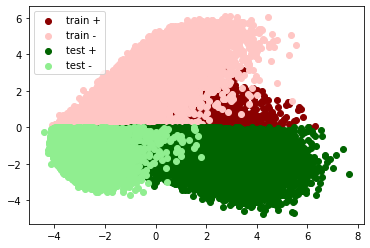

In [69]:
plt.scatter(X_pca_train_1[:, 0], X_pca_train_1[:, 1], color="#8B0000", label='train +')
plt.scatter(X_pca_train_2[:, 0], X_pca_train_2[:, 1], color="#ffc6c4", label='train -')
plt.scatter(X_pca_test_1[:, 0], X_pca_test_1[:, 1], color="#006400", label='test +')
plt.scatter(X_pca_test_2[:, 0], X_pca_test_2[:, 1], color="#90EE90", label='test - ')
plt.legend()

In [70]:
def plot_test_samples(samples, labels, outputs, dev_from_mean = 0.05): # dev_from_mean used to quantify uncertainty. E.g. 0.1 means images with predicitons between 0 and 1

  samples = samples[np.where(np.abs(outputs.detach().numpy() - 0.5) < dev_from_mean)[0]]
  labels = labels[np.where(np.abs(outputs.detach().numpy() - 0.5) < dev_from_mean)[0]]

  i = min(4, int(len(labels) ** 0.5))
  j = min(4, int(len(labels) ** 0.5))
  print(i, j)
  if i == 0 or i == 1:
    raise Exception(f"Not enough images to display with prob between {0.5 - dev_from_mean} and {0.5 + dev_from_mean}")
  fig, ax = plt.subplots(i,j)
  for x in range(i):
    for y in range(j):
      ax[x][y].imshow(samples[x * i + y].reshape(28, 28))
      ax[x][y].title.set_text(f"Class: {int(labels[x * i + y].item())}")

  title = fig.suptitle(f'Number of images w/ prob between {0.5 - dev_from_mean} and {0.5 + dev_from_mean}: {len(labels)}', y=1.05) 
  fig.set_tight_layout(True)

#### LOG

In [75]:
from os.path import exists

r_st = torch.ones(Y[train_idx].shape)
tmp_X = torch.FloatTensor(X[train_idx])
tmp_Y = torch.FloatTensor(Y[train_idx])

model = rba_train(tmp_X, tmp_Y, r_st, r_st, lr = 0.02, max_itr=1500)

Loss at step 0: 0.7313132882118225
Loss at step 1000: 0.000771635677665472


Target Loss: 0.20465360581874847. Target Accuracy: 0.9285269379615784
ECE: 0.3052326425440962
4 4


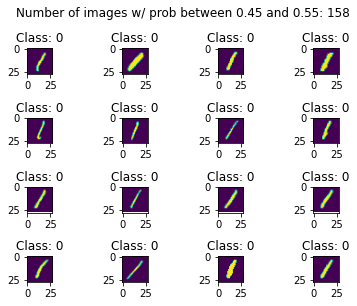

In [76]:
loss, outputs, acc = log_test(model, torch.FloatTensor(X[test_idx]), torch.FloatTensor(Y[test_idx]), torch.ones(Y[test_idx].shape))
pred_y_pairs = np.concatenate((outputs.detach().numpy(), Y[test_idx]), axis=1)
ece = binary_ece(pred_y_pairs, n_bins=10)
print(f"ECE: {ece}")

plot_test_samples(X[test_idx], Y[test_idx], outputs)

#### RBA

In [82]:
pca_kde = get_pca_kernel_density_estimator(X[train_idx], X[test_idx], bandwidth = 0.7)
r_st = pca_kde(X[train_idx])

In [83]:
rba_model = rba_train(tmp_X, tmp_Y, r_st, torch.ones((tmp_Y.shape[0], 1)), lr = 0.008, max_itr=1000, weight_decay=0.005)

Loss at step 0: 2.017653226852417
Loss at step 1000: 0.010025011375546455


Target Loss: 0.5606018900871277. Target Accuracy: 0.7827513813972473
ECE:  0.25145154397614006
4 4


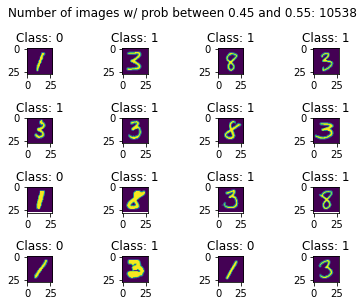

In [85]:
r_st = pca_kde(X[test_idx])
loss, outputs, acc = log_test(rba_model, torch.FloatTensor(X[test_idx]), torch.FloatTensor(Y[test_idx]), r_st)
pred_y_pairs = np.concatenate((outputs.detach().numpy(), Y[test_idx]), axis=1)
ece = binary_ece(pred_y_pairs, n_bins=10)
print("ECE: ", ece)

plot_test_samples(X[test_idx], Y[test_idx], outputs, dev_from_mean = 0.05)

### Covariate shift different ratios of numbers within test vs train

In [26]:
train_data_38 = mnist_trainset.data[
  np.logical_or((mnist_trainset.targets == 3), (mnist_trainset.targets == 8))
] 
train_data_38_labels = np.ones((len(train_data_38), 1))

train_data_17 = mnist_trainset.data[
  np.logical_or((mnist_trainset.targets == 1), (mnist_trainset.targets == 7))
] 
train_data_17_labels = np.zeros((len(train_data_17), 1))

curlyRatio = sum((mnist_trainset.targets == 3)).item() / sum((mnist_trainset.targets == 8)).item()
straightRatio = sum((mnist_trainset.targets == 1)).item() / sum((mnist_trainset.targets == 7)).item()

print(f"Ratio of 3:8 = {curlyRatio}. Ratio of 1:7 = {straightRatio}")

train_X = np.concatenate((train_data_38, train_data_17), dtype = float)
train_X /= 255
train_Y = np.concatenate((train_data_38_labels, train_data_17_labels))

train_X, train_Y = unison_shuffled_copies(train_X, train_Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  import sys


Ratio of 3:8 = 1.0478550675098275. Ratio of 1:7 = 1.0761372705506784


In [27]:
test_data_3 = (mnist_testset.data[(mnist_testset.targets == 3)])
test_data_3 = test_data_3[:int(0.5 * len(test_data_3))]

test_data_8 = mnist_testset.data[(mnist_testset.targets == 8)]

test_data_38 = np.concatenate((test_data_3, test_data_8), dtype = float)
test_data_38_labels = np.ones((len(test_data_38), 1))

test_data_1 = mnist_testset.data[(mnist_testset.targets == 1)] 
test_data_7 = mnist_testset.data[(mnist_testset.targets == 7)]
test_data_7 = test_data_7[:int(0.5 * len(test_data_7))]

test_data_17 = np.concatenate((test_data_1, test_data_7), dtype = float)
test_data_17_labels = np.zeros((len(test_data_17), 1))

curlyRatio = len(test_data_3) / len(test_data_8)
straightRatio = len(test_data_1) / len(test_data_7)

print(f"Ratio of 3:8 = {curlyRatio}. Ratio of 1:7 = {straightRatio}")

test_X = np.concatenate((test_data_38, test_data_17), dtype = float)
test_X /= 255.0
test_Y = np.concatenate((test_data_38_labels, test_data_17_labels))

test_X, test_Y = unison_shuffled_copies(test_X, test_Y)

Ratio of 3:8 = 0.5184804928131417. Ratio of 1:7 = 2.208171206225681


In [28]:
train_X_flattened = torch.flatten(torch.Tensor(train_X), start_dim=1)
test_X_flattened = torch.flatten(torch.Tensor(test_X), start_dim=1)
train_Y = torch.FloatTensor(train_Y)
test_Y = torch.FloatTensor(test_Y)

#### LOG

In [29]:
from os.path import exists

r_st = torch.ones(train_Y.shape)

model = rba_train(train_X_flattened, train_Y, r_st, r_st, lr = 0.01, max_itr=5000)

Loss at step 0: 0.693993330001831
Loss at step 1000: 0.0006959741003811359
Loss at step 2000: 0.00029839863418601453
Loss at step 3000: 0.018839675933122635
Loss at step 4000: 0.002459159353747964


In [30]:
loss, outputs, acc = log_test(model, test_X_flattened, test_Y, torch.ones(test_Y.shape))
pred_y_pairs = np.concatenate((outputs.detach().numpy(), test_Y), axis=1)
ece = binary_ece(pred_y_pairs, n_bins=1)
print(f"ECE: {ece}")

plot_test_samples(test_X, test_Y, outputs)

Target Loss: 0.031841132789850235. Target Accuracy: 0.9926470518112183
ECE: 0.5185862253693974
1 1


Exception: ignored

#### RBA

In [51]:
pca_kde = get_pca_kernel_density_estimator(train_X_flattened, test_X_flattened)
r_st = pca_kde(train_X_flattened)

In [52]:
rba_model = rba_train(train_X_flattened, train_Y, r_st, torch.ones(train_Y.shape), lr = 0.008, max_itr=4000, weight_decay=0.01)

Loss at step 0: 0.6946559548377991
Loss at step 1000: 0.0010911847930401564
Loss at step 2000: 0.0002219852467533201
Loss at step 3000: 0.00010927642870228738


In [55]:
r_st = pca_kde(test_X_flattened)
print(min(r_st), max(r_st))
loss, outputs, acc = log_test(rba_model, test_X_flattened, test_Y, r_st)
pred_y_pairs = np.concatenate((outputs.detach().numpy(), test_Y), axis=1)
ece = binary_ece(pred_y_pairs, n_bins=1)
print(f"ECE: {ece}")

plot_test_samples(test_X, test_Y, outputs)

tensor([0.2656]) tensor([3.0380])
Target Loss: 0.045651283115148544. Target Accuracy: 0.9907289147377014
ECE: 0.5174270220996474
1 1


Exception: ignored